In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [61]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv", index_col='PassengerId')
test_data = pd.read_csv("/kaggle/input/titanic/test.csv", index_col='PassengerId')

In [62]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [63]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


# Step 1: Data Wrangling

In [64]:
# Missing Values
print(train_data.isna().sum())
print(test_data.isna().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64
Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


In [65]:
#fill missing values
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

In [66]:
# Unique Values
print(train_data.nunique())
print(test_data.nunique())

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64
Pclass        3
Name        418
Sex           2
Age          79
SibSp         7
Parch         8
Ticket      363
Fare        169
Cabin        76
Embarked      3
dtype: int64


In [67]:
datasets = [train_data, test_data] # List of train and test datasets for looping conveniently

First, I'll explore
-  Cabin (too many missing values)
-  Ticket, Name (too many unique values)
to see if I can extract useful info from each of them.

### Cabin
Cabin number can inform us about the location of each passenger on the ship.

In [68]:
train_data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [69]:
# Extract prefix of Cabin
def extract_cabin_prefix(cabin_string):
    return str(cabin_string)[0]

In [70]:
for df in datasets:
    df['Cabin'] = df['Cabin'].apply(extract_cabin_prefix)

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

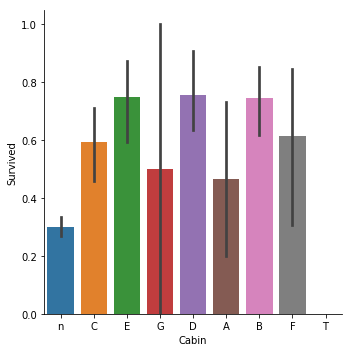

In [72]:
sns.catplot(x='Cabin',y='Survived',kind='bar',data=train_data)

We see that passengers on different cabins had different survival rates. (Note: missing values are represented by cabin 'n'.)

### Ticket
Now, I will count ticket frequencies to identify who shares cabin with whom.

In [73]:
# Count ticket frequencies
ticket_freq = {}
for df in datasets:
    for ticket in df['Ticket']:
        if ticket in ticket_freq:
            ticket_freq[ticket] += 1
        else:
            ticket_freq[ticket] = 1

In [74]:
for df in datasets:
    df['Ticket_freq'] = df['Ticket'].replace(ticket_freq)

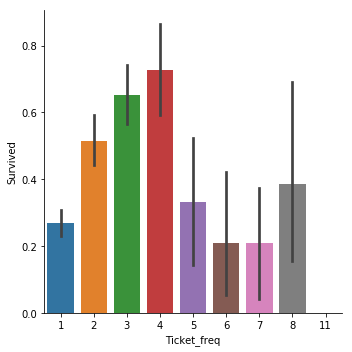

In [75]:
sns.catplot(x='Ticket_freq',y='Survived',kind='bar',data=train_data)

We see that ticket frequencies (i.e. number of companions including self) is quite informative.

In [76]:
# Now we can drop the Ticket column
for df in datasets:
    df.drop(['Ticket'], axis=1, inplace=True)

### Name
We can extract the titles of the passengers from their names. This can inform us about their genders, marital and social status.

In [77]:
train_data['Name']

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [78]:
# Create a function to extract titles from the Name feature
import re

def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    else:
        return ""

In [79]:
# Try extracting to see if our regular expression is working as intended
print(extract_title('Braund, Mr. Owen Harris'))
print(extract_title('Futrelle, Mrs. Jacques Heath (Lily May Peel)'))
print(extract_title('Johnston, Miss. Catherine Helen "Carrie"'))

Mr
Mrs
Miss


In [80]:
for df in datasets:
    df['Title'] = df['Name'].apply(extract_title)

In [81]:
# See the list of all unique titles
np.union1d(train_data['Title'].unique(), test_data['Title'].unique())

array(['Capt', 'Col', 'Countess', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady',
       'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev',
       'Sir'], dtype=object)

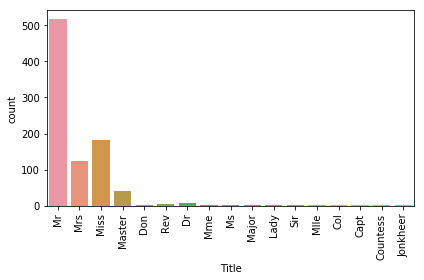

In [82]:
#Plot distribution of titles
ax = sns.countplot(train_data['Title'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

In [83]:
# Minority titles
other_titles = ['Don','Dona', 'Rev', 'Dr', 'Major', 'Lady',
                'Sir', 'Col', 'Capt', 'Countess','Jonkheer']

In [84]:
# Replace titles with appropriate groupings
for df in datasets:
    df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss') # Mlle = Ms = Miss
    df['Title'] = df['Title'].replace('Mme', 'Mrs') # Madame = Mrs
    df['Title'] = df['Title'].replace(other_titles, 'Others') # Others

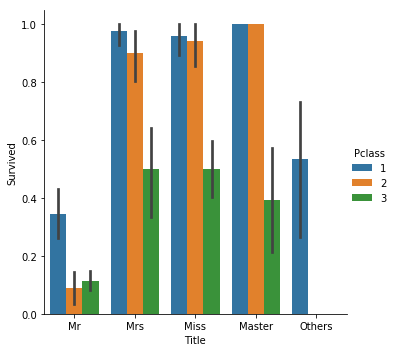

In [85]:
sns.catplot(x='Title',y='Survived',hue='Pclass',kind='bar',data=train_data)

Observations
- Kids (Master) from Upper and Middle classes were 'guaranteed' to survive! I can imagine that in the real event, the crew chose to help these kids first.
- Males (Mr) were significantly more likely to die. It could be that they sacrificed themshelves by helping others escape the sinking ship first and couldn't escape in time.
- There isn't much difference between Miss and Mrs.

# Step 2: Exploratory Data Analysis
To get a sense of how current features affect the results, we do EDA for these features
- Pclass
- Sex
- Age
- Fare
- Embarked

### Passenger Class (Upper, Middle, Lower)

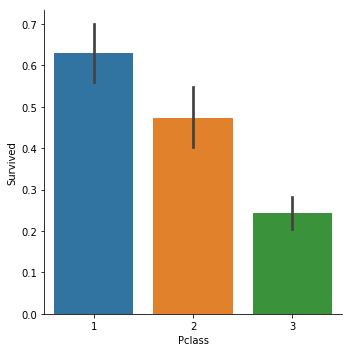

In [86]:
sns.catplot(x='Pclass',y='Survived',kind='bar',data=train_data)

It's very obvious that Upper class passengers had the highest chance of survival. One simple model would be to predict all the Upper class, half the Middle class and none the Lower class as survivors.

### Sex (Male, Female)

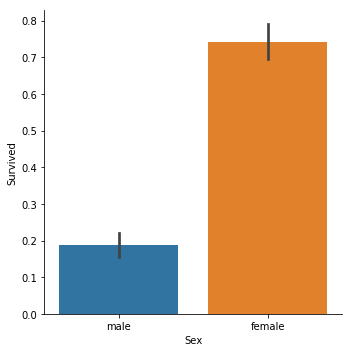

In [87]:
sns.catplot(x='Sex',y='Survived',kind='bar',data=train_data)

It's also very obvious that Females had a much higher chance of surviving than Males. Again, a possible, simple model would be to predict all females and none of males to survive.

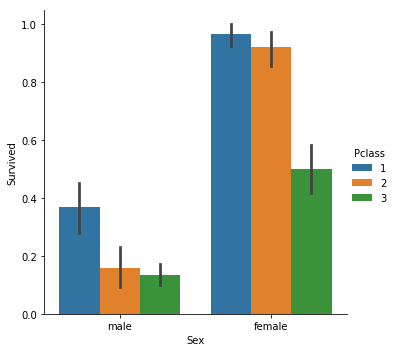

In [88]:
sns.catplot(x='Sex',y='Survived',hue='Pclass',kind='bar',data=train_data)

Considering both Pclass and Sex, we see that for males, Upper class passengers had a significantly higher chance of survival than the other two classes, but it's still less than 50%. For females, however, the Upper and Middle classes were almost guaranteed to survive.

### Age
Previously, we see that 'Master' title (boys and teenagers) from Upper and Middle classes were almost guaranteed to survive. Now we consider Age feature to include both sexes.

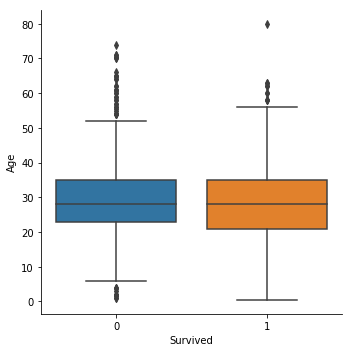

In [89]:
sns.catplot(x='Survived',y='Age', kind='box', data=train_data)

If we consider age alone, it's not a very good predictor of who survives.

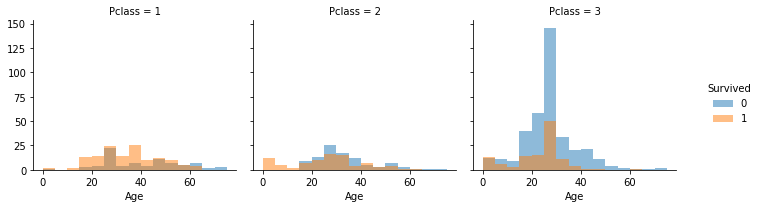

In [90]:
age_bins = np.arange(0, 80, 5)
ax = sns.FacetGrid(train_data, col='Pclass', hue='Survived',
                   margin_titles=True, size=3, aspect=1.1)
ax.map(sns.distplot, 'Age', bins=age_bins, kde=False, hist_kws=dict(alpha=0.5))
ax.add_legend()

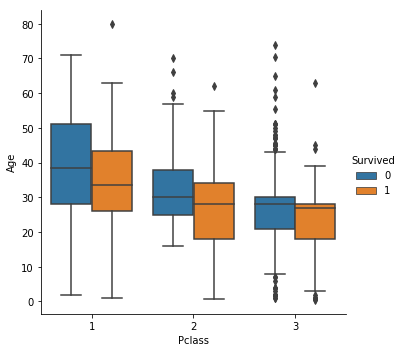

In [91]:
sns.catplot(x='Pclass',y='Age', kind='box', hue='Survived', data=train_data)

From the above boxplots, given a class, younger passengers have higher chance at survival than older ones. A combination of Pclass and Age may help separate groups of survivers from casualties.

### Fare
It is expected that Fare and Pclass should be correlated.

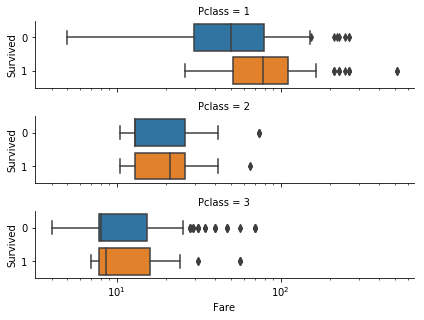

In [92]:
# Citation: http://seaborn.pydata.org/tutorial/categorical.html
g = sns.catplot(x="Fare", y="Survived", row="Pclass",
                kind="box", orient="h", height=1.5, aspect=4,
                data=train_data.query("Fare > 0"))
g.set(xscale="log")

As we see from the boxplots, the upper the class, the higher the fares.

### Embarked
Now, let's see if the embarked location relate to the survival rate.

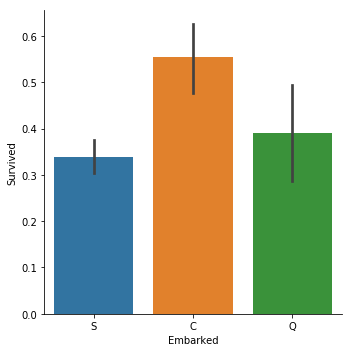

In [93]:
sns.catplot(x='Embarked',y='Survived',kind='bar',data=train_data)

It appears passengers who embarked at port C had a higher chance of surviving than others.

# Step 3: Feature Engineering
- Create 'FamilySize' feature
- Adjust Fare to account for group ticket
- Feature Scaling and Binning

### Create 'FamilySize' feature
Family size = Number of siblings/spouses + Number of parents/children + 1 (self)

In [94]:
for df in datasets:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

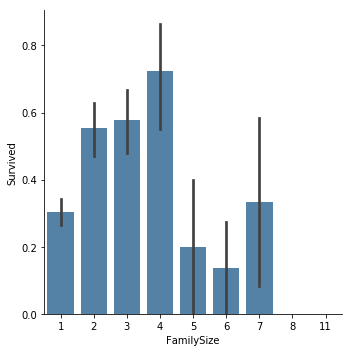

In [95]:
sns.catplot(x='FamilySize',y='Survived',color='steelblue',kind='bar',data=train_data)

The larger the family size, the lower the chance of survival.

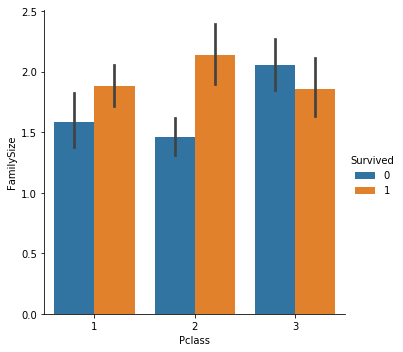

In [96]:
sns.catplot(x='Pclass',y='FamilySize',hue='Survived',kind='bar',data=train_data)

However, if we include the Pclass factor, the upper the class, the bigger size families had more chance of survival. This is not conflicting with previous observation of FamilySize feature alone, given that a lot of lower class passengers had large family size as confirmed in the below charts.

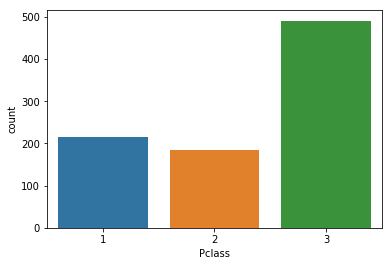

In [97]:
sns.countplot(x='Pclass', data=train_data)

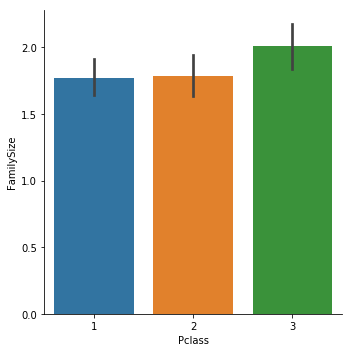

In [98]:
sns.catplot(x='Pclass',y='FamilySize',kind='bar',data=train_data)

### Adjust Fare to account for group ticket

Text(0.5, 1.0, 'Fare Distribution')

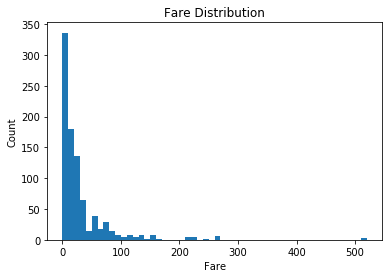

In [99]:
#Plot distribution of fares
binwidth = 10
plt.hist(train_data['Fare'], bins=range(0, int(max(train_data['Fare'])) + binwidth, binwidth))
plt.xlabel('Fare')
plt.ylabel('Count')
plt.title('Fare Distribution')

In [100]:
for df in datasets:
    df['Fare_Per_Person'] = df['Fare']/df['FamilySize']

Text(0.5, 1.0, 'Fare per Person Distribution')

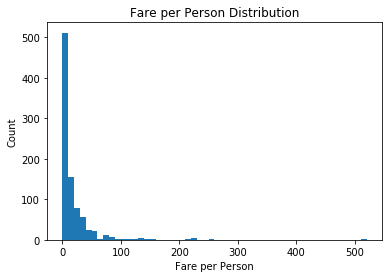

In [101]:
#Plot distribution of fares
binwidth = 10
plt.hist(train_data['Fare_Per_Person'], bins=range(0, int(max(train_data['Fare_Per_Person'])) + binwidth, binwidth))
plt.xlabel('Fare per Person')
plt.ylabel('Count')
plt.title('Fare per Person Distribution')

We see that Fare per Person is more continuous than Fare.

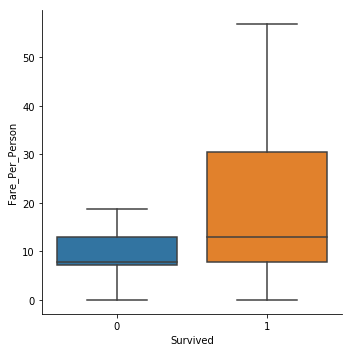

In [102]:
sns.catplot(x='Survived',y='Fare_Per_Person', kind='box', showfliers = False, data=train_data)

From the boxplot, the higher the fare per person, the higher the chance of survival.

### Feature Scaling and Binning
These are the continous features that need scaling and/or binning
- Age: Scaling is enough (no outliers)
- Fare per Person: Binning to filter out outliers

#### Scaling Age

In [103]:
#Scale Age to have a range of 1
for df in datasets:
    df['Scaled_Age'] = df['Age']/(df['Age'].max() - df['Age'].min())

#### Binning Fare per Person

Text(0.5, 1.0, 'Sub 50 Fare per Person Distribution')

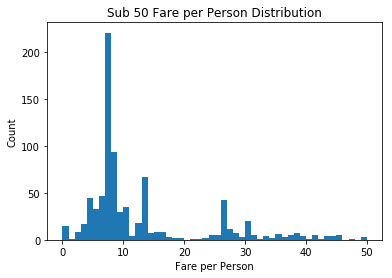

In [104]:
binwidth = 1
plt.hist(train_data['Fare_Per_Person'][train_data['Fare_Per_Person'] <= 50],
         bins=range(0, 50 + binwidth, binwidth))
plt.xlabel('Fare per Person')
plt.ylabel('Count')
plt.title('Sub 50 Fare per Person Distribution')

In [105]:
# Cut the fare into bins to prevent outliers from distorting the data
for df in datasets:
    df['Fare_tier'] = pd.cut(df['Fare_Per_Person'], bins=[-1,9,14,27,80,550], labels=False) + 1

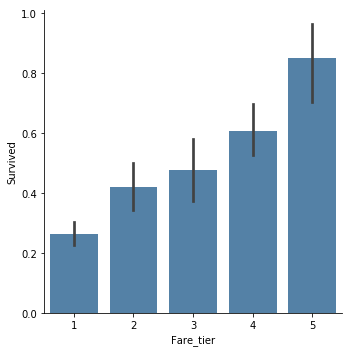

In [106]:
sns.catplot(x='Fare_tier',y='Survived',color='steelblue',kind='bar',data=train_data)

We see that the higher the fare tier, the higher the chance of surviving.

In [107]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_freq,Title,FamilySize,Fare_Per_Person,Scaled_Age,Fare_tier
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,n,S,1,Mr,2,3.62500,0.276451,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C,2,Mrs,2,35.64165,0.477507,4
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,n,S,1,Miss,1,7.92500,0.326715,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C,S,2,Mrs,2,26.55000,0.439809,3
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,n,S,1,Mr,1,8.05000,0.439809,1


# Step 4: Encoding Categorical Data
Categorical features that need to be one-hot encoded:
- Pclass
- Sex
- Cabin
- Embarked
- Title

In [108]:
OH_columns = ['Pclass', 'Sex', 'Cabin', 'Embarked','Title']
train_data_final = pd.get_dummies(train_data, columns=OH_columns, prefix = OH_columns)
test_data_final = pd.get_dummies(test_data, columns=OH_columns, prefix = OH_columns)

In [109]:
missing_columns = []
# There could be missing columns in the one-hot encoded dataset since there could be some values
# that are present in the train dataset and not in the test dataset
for column in list(train_data_final.columns):
    if column not in list(test_data_final.columns):
        missing_columns.append(column)
        
print(missing_columns)

['Survived', 'Cabin_T']


In [110]:
test_data_final['Cabin_T'] = 0

In [111]:
# Manually insert the missing columns in the test dataset
new_column_order = list(test_data_final.columns)
new_column_order.insert(new_column_order.index('Cabin_n'), new_column_order.pop(new_column_order.index('Cabin_T')))

In [112]:
# Rearrange the order to match the train dataset
test_data_final = test_data_final.reindex(columns= new_column_order)

In [113]:
test_data_final.head()

,Name,Age,SibSp,Parch,Fare,Ticket_freq,FamilySize,Fare_Per_Person,Scaled_Age,Fare_tier,...,Cabin_T,Cabin_n,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,"Kelly, Mr. James",34.5,0,0,7.8292,1,1,7.829200,0.454965,1,...,0,1,0,1,0,0,0,1,0,0
893,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,7.0000,1,2,3.500000,0.619807,1,...,0,1,0,0,1,0,0,0,1,0
894,"Myles, Mr. Thomas Francis",62.0,0,0,9.6875,1,1,9.687500,0.817618,2,...,0,1,0,1,0,0,0,1,0,0
895,"Wirz, Mr. Albert",27.0,0,0,8.6625,1,1,8.662500,0.356060,1,...,0,1,0,0,1,0,0,1,0,0
896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,12.2875,2,3,4.095833,0.290123,1,...,0,1,0,0,1,0,0,0,1,0


In [114]:
# Drop unusued columns
unused_columns = ['Name', 'Age', 'Fare', 'Fare_Per_Person']
train_data_final.drop(unused_columns, axis=1, inplace=True)
test_data_final.drop(unused_columns, axis=1, inplace=True)

In [115]:
train_data_final.head()

,Survived,SibSp,Parch,Ticket_freq,FamilySize,Scaled_Age,Fare_tier,Pclass_1,Pclass_2,Pclass_3,...,Cabin_T,Cabin_n,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,1,2,0.276451,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
2,1,1,0,2,2,0.477507,4,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1,0,0,1,1,0.326715,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
4,1,1,0,2,2,0.439809,3,1,0,0,...,0,0,0,0,1,0,0,0,1,0
5,0,0,0,1,1,0.439809,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0


Now we have our final processed and engineered datasets.

In [116]:
X = train_data_final.drop(['Survived'], axis = 1)
y = train_data_final['Survived']
X_test = test_data_final

In [117]:
X.shape

(891, 28)

In [118]:
X_test.shape

(418, 28)

# Step 5: Model Selection

In [119]:
# Import Models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Import metrics and parameter tuning functions
from sklearn.metrics import mean_absolute_error, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [120]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [121]:
#Instantiate models with default parameters
XGB = XGBClassifier(random_state=0)
ADA = AdaBoostClassifier(random_state=0)
RF = RandomForestClassifier(random_state=0)
GB = GradientBoostingClassifier(random_state=0)
SVM = SVC(kernel='rbf', random_state=0)
LR = LogisticRegression(random_state=0)
DT = DecisionTreeClassifier(random_state=0)

models = [XGB, ADA, RF, GB, SVM, LR, DT]
model_names = ['XGBoost', 'AdaBoost', 'Random Forest', 'Gradient Boost',
               'SVM', 'Logistic Regression','Decision Tree']

In [122]:
#Calculate accuracies for all model using cross-validation method
n_models = len(models)

for i in range(0, n_models):
    model = models[i]
    model_name = model_names[i]
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    accuracy = scores.mean()
    print('The mean accuracy for {:<20} is {:>10.3%}'.format(model_name, accuracy))

The mean accuracy for XGBoost              is    83.277%
The mean accuracy for AdaBoost             is    81.033%
The mean accuracy for Random Forest        is    79.463%
The mean accuracy for Gradient Boost       is    82.829%
The mean accuracy for SVM                  is    83.386%
The mean accuracy for Logistic Regression  is    81.931%
The mean accuracy for Decision Tree        is    79.240%


It appears XGBoost, SVM, Random Forest, and AdaBoost are promising and can be fine tuned for better performance. (I choose XGBoost over Gradient Boost because GB is pretty slow)

# Step 6: Fine tuning parameters

In [123]:
# Create a function to return the best model given choices of hyper parameters
def get_best_model(model, parameters):
    ''' Return the best tuned model with its accuracy
    INPUT : model - untuned model
            parameters - dictionary of tuning hyper parameters
    OUTPUT: best_model - the best tuned model
            accuracy - model cv accuracy
    '''
    scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(model, parameters, scoring = scorer, cv=3)
    grid_fit = grid_obj.fit(X, y)
    best_model = grid_fit.best_estimator_
    accuracy = grid_fit.best_score_
    
    return best_model, accuracy

### Model 1: XG Boost

In [ ]:
# For quick committing, I commented out the GridSearchCV
'''
parameters = {"max_depth": [3, 4, 5, 6, 7],
              "min_child_weight": [1, 1.6],
              "subsample": [0.9],
              "colsample_bytree": [0.5],
              "eta": [0.005, 0.01, 0.05],
              "gamma": [1, 2],
              "lambda": [8, 12, 16]}

XGB_best_model, XGB_best_accuracy = get_best_model(XGB, parameters)
print(XGB_best_model)
print('Accuracy of best XGB model is: {:.3%}'.format(XGB_best_accuracy))
'''

In [124]:
# Best XGB model (Create a separate one to avoid long commit waiting time)
#'''
parameters = {"max_depth": [6],
              "min_child_weight": [1],
              "subsample": [0.9],
              "colsample_bytree": [0.5],
              "eta": [0.005],
              "gamma": [1],
              "lambda": [8]}

XGB_best_model, XGB_best_accuracy = get_best_model(XGB, parameters)
print(XGB_best_model)
print('Accuracy of best XGB model is: {:.3%}'.format(XGB_best_accuracy))
#'''

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.005, gamma=1,
              lambda=8, learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)
Accuracy of best XGB model is: 84.175%


The accuracy for XGB is 84.175% Impressive on the training set but the performance could drop on the testing set.

### Model 2: SVM

In [125]:
#'''
parameters = {"C": [0.1, 0.3, 0.5, 1, 2, 3, 5, 7, 10],
              "kernel": ['rbf','linear','poly'],
              "degree": [2, 3, 4]}

SVM_best_model, SVM_best_accuracy = get_best_model(SVC(), parameters)
print(SVM_best_model)
print('Accuracy of best SVM model is: {:.3%}'.format(SVM_best_accuracy))
#'''

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy of best SVM model is: 83.502%


The accuracy is 83.502% for SVC with 'rbf' kerne and C = 1.

### Model 3: Random Forest

In [126]:
'''
parameters = {"criterion": ['gini','entropy'],
              "min_samples_leaf": [1, 5, 10],
              "min_samples_split": [2, 4, 10, 12, 16],
              "max_depth": [2, 3, 4, 5, 6],
              "n_estimators": [500, 100, 400, 700, 1000]}

RF_best_model, RF_best_accuracy = get_best_model(RF, parameters)
print(RF_best_model)
print('Accuracy of best RF model is: {:.3%}'.format(RF_best_accuracy))
'''

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Accuracy of best RF model is: 83.502%


In [131]:
#'''
parameters = {"criterion": ['gini'],
              "min_samples_leaf": [1],
              "min_samples_split": [12],
              "max_depth": [5], #shallow to prevent overfitting
              "n_estimators": [100]}

RF_best_model, RF_best_accuracy = get_best_model(RandomForestClassifier(), parameters)
print(RF_best_model)
print('Accuracy of best RF model is: {:.3%}'.format(RF_best_accuracy))
#'''

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy of best RF model is: 83.277%


The accuracy is 83.277%, a big improvement from the base model.

### Model 4: AdaBoost

In [132]:
#'''
parameters = {"n_estimators": [30, 50, 100, 150, 300],
              "learning_rate": [0.01, 0.03, 0.1, 0.3, 1, 3, 10]}

ADA_best_model, ADA_best_accuracy = get_best_model(ADA, parameters)
print(ADA_best_model)
print('Accuracy of best XGB model is: {:.3%}'.format(ADA_best_accuracy))
#'''

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=100, random_state=0)
Accuracy of best XGB model is: 82.828%


The accuracy of AdaBoost is 82.828%

# Step 7: Predicting Test Set

I tried the best models on the the testing dataset and got the best score of 78.947% on the public leaderboard with tuned SVC model with rbf kernel. This shows that our model overfits a little bit towards the training set. This signals that the testing set has some different passenger profile than the training one.

Ideas for future improvements:
- Try binning the Age feature to separate kids from the adults
- Filter out all passengers with title Masters and predict all of them to be alive.
- Try grouping passengers by last names.
- Try polynomial terms such as Pclass^2
- Try building a deep learning network with TensorFlow keras

In [133]:
final_model = SVM_best_model

In [134]:
test_pred = final_model.predict(X_test)

In [135]:
output = pd.DataFrame({'PassengerId': X_test.index, 'Survived': test_pred})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
